# Analysis of how much data shuffling affects learning curves

We generated data for LCs over multiple data shuffles.

Conclusion:
1. Standard deviation is inversely proportional to the subset size (in CCLE). Certain shuffles generate LC that does not result in a successful power law fit. As a result, we generate data for multiple seeds and aggregate across runs via median. We then fit a power law to the aggregated LC data.
2. Runs over many seeds can be very expensive especially for NNs. We need to decide how many seeds we need! --> can go Discussion
3. Should we consider to drop shards which exhibit high variance across seeds? Is this what Mukherjee (2003) did?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


### Load results from runs

In [2]:
# Runs dir
# CCLE - very small difference when usgin default and LS-best HPs to generate LC
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_no-HPO')
base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_LS-Best')

In [3]:
runs = glob(str(base_dir/'*'))

### Plot all results

In [4]:
metric_name = 'mean_absolute_error'
# xtick_scale='linear'; ytick_scale='linear'
xtick_scale='log2';   ytick_scale='log2'

shard_min_idx=0
# shard_min_idx=1

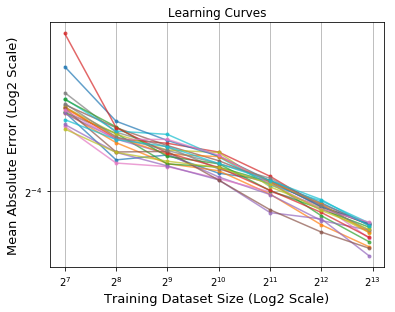

In [5]:
pp_utils.plot_lc_multi_runs(runs, metric_name=metric_name, tr_set='te',
                            shard_min_idx=shard_min_idx, cv_folds=1,
                            xtick_scale=xtick_scale, ytick_scale=ytick_scale)

In [6]:
### Fit each LC set

In [7]:
# Fit data
# pp_utils.fit_lc_multi_runs(runs, metric_name=metric_name, tr_set='te',
#                              shard_min_idx=shard_min_idx, cv_folds=1,
#                              xtick_scale=xtick_scale, ytick_scale=ytick_scale)

In [8]:
# x, y = get_xy(Path(runs[2]), metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1)
# ax = lrn_crv_plot.plot_lrn_crv_power_law(x=x, y=y, marker='.', alpha=0.7)

### Aggregate results over runs

In [9]:
scores = []
for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if i==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])

In [10]:
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)

In [11]:
scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

### LC of mean and errorbars

In [12]:
figsize=(6,4.5)
metric_name='mean_absolute_error'
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_kwargs = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

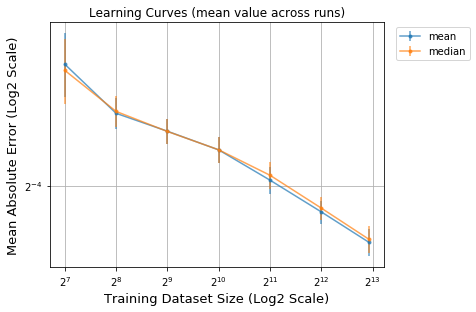

In [13]:
df = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ]

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df['tr_size'], y=df['mean'], yerr=df['std'], ax=ax, marker='.', alpha=0.7,
            title='Learning Curves (mean value across runs)', **plot_kwargs, label='mean')

ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df['tr_size'], y=df['median'], yerr=df['std'], ax=ax, marker='.', alpha=0.7,
            title='Learning Curves (mean value across runs)', **plot_kwargs, label='median')

### Fit power-law to LC of mean across shuffles

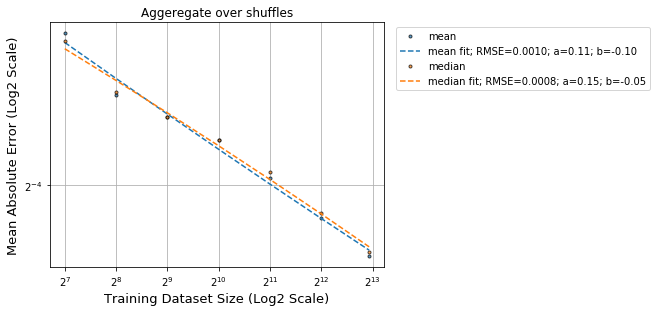

In [32]:
ax, _, _ = lrn_crv_plot.plot_lrn_crv_power_law( x=df['tr_size'], y=df['mean'], title='Aggeregate over shuffles', **plot_kwargs, label='mean' );
ax, _, _ = lrn_crv_plot.plot_lrn_crv_power_law( x=df['tr_size'], y=df['median'], title='Aggeregate over shuffles', **plot_kwargs, label='median', ax=ax );

### Plot score deviation (std) vs shard across shuffles

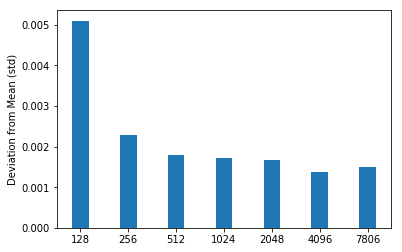

In [33]:
# matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py
y_err = df['std'].values
ind = np.arange(len(y_err))
width = 0.35  # width of the bars

p1 = plt.bar(ind, y_err, width)
plt.ylabel('Training Set Size')
plt.ylabel('Deviation from Mean (std)') # TODO: should we use a different metric which is more robust to outliers such as IQR?
plt.xticks(ind, [str(sz) for sz in df['tr_size'].values])
plt.show()